In [1]:
import os
import gc
import glob
import math
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

import albumentations as A
from albumentations.pytorch import ToTensorV2

import sys
import pickle
# sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/rangerdeeplearningoptimizer/ranger')
# import timm
import wandb
from ranger import Ranger

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
class Mish_layer(nn.Module):
    '''
    The class represents Mish activation function.
    '''
    def __init__(self):
        super(Mish_layer,self).__init__()
    def forward(self,x):
        return x*torch.tanh(F.softplus(x))

In [3]:
def set_seed(seed):
    #Sets the seed for Reprocudibility
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        
set_seed(7)

In [4]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb") 

wandb.login(key = wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
config = dict(
    batch_size = 64,
    epochs = 120,
    learning_rate = 1e-4
    )

In [6]:
def img_paths_list(root_dir):
    root_list = glob.glob(root_dir)
    data = []
    for img_path in tqdm(root_list):
        data.append(img_path)
        
    return data

In [7]:
data_root_dir = r'../input/gsocml4scimodel1/Model_I/axion/*'
dataset_img_paths_list = img_paths_list(data_root_dir)

test_data_root_dir = r'../input/gsocml4scimodel1test/Model_I_test/axion/*'
test_paths_list = img_paths_list(test_data_root_dir)

  0%|          | 0/28897 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
val_split = int(0.1 * len(dataset_img_paths_list))

random.shuffle(dataset_img_paths_list)

val_paths_list = dataset_img_paths_list[:val_split]
train_paths_list = dataset_img_paths_list[val_split:]

assert len(dataset_img_paths_list) == (len(train_paths_list) + len(val_paths_list))

len(train_paths_list), len(val_paths_list), len(test_paths_list)

(26008, 2889, 5000)

In [9]:
def pickelize_file(dicto, pickle_path):
    file_to_write = open(pickle_path, "wb")
    pickle.dump(dicto, file_to_write)
    
    print("Pickleized successfully!")
    
pickelize_file(train_paths_list, "train_paths_list.pickle")
pickelize_file(val_paths_list, "val_paths_list.pickle")

Pickleized successfully!
Pickleized successfully!


In [10]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_and_labels_list,transform = None):
        self.data = img_paths_and_labels_list
        self.transform = transform
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        path = self.data[idx]
        array = np.load(path, allow_pickle = True)
        img = array[0]
        img = img.astype('float32')
        mass = torch.tensor(-(math.log10(array[1])))
       
        if self.transform:
            aug = self.transform(image = img)
            img = aug['image']      

        return img, mass

In [11]:
train_transforms = A.Compose(
            [
#                 A.CenterCrop(height = 100, width = 100, p=1.0),
                A.HorizontalFlip(p = 0.5),
                A.VerticalFlip(p = 0.5),
                A.Rotate(limit = 360, p = 0.4),
                ToTensorV2()
            ]
        )


test_transforms = A.Compose(
            [
#                 A.CenterCrop(height = 100, width = 100, p=1.0),
                ToTensorV2()
            ]
        )

In [12]:
train_dataset = CustomDataset(train_paths_list, transform = test_transforms)
print(len(train_dataset))

val_dataset = CustomDataset(val_paths_list, transform = test_transforms)
print(len(val_dataset))

test_dataset = CustomDataset(test_paths_list,transform = test_transforms)
print(len(test_dataset))

26008
2889
5000


In [13]:
train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle = True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = config['batch_size'], shuffle = False, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False, num_workers = 2)

In [14]:
single_batch = next(iter(test_loader))
single_batch[0].shape

torch.Size([64, 1, 150, 150])

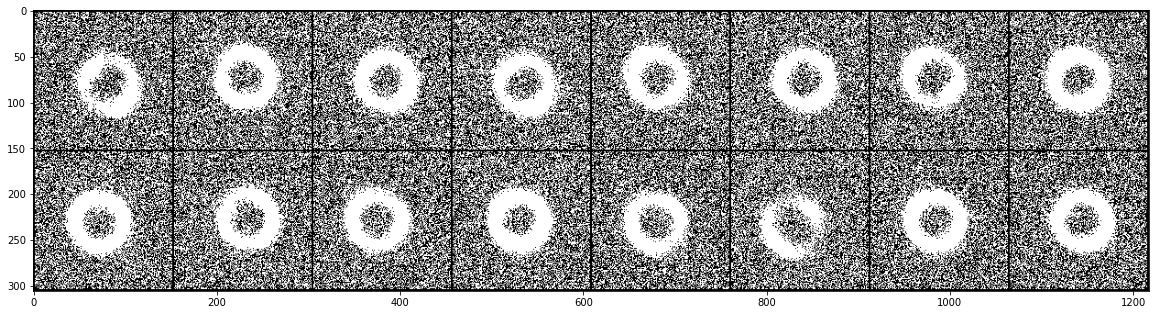

In [15]:
single_batch_grid = utils.make_grid(single_batch[0][:16], nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [16]:
class ChannelAttention(nn.Module):
    def __init__(self,channel,reduction = 16):
        super().__init__()
        self.maxpool=nn.AdaptiveMaxPool2d(1)
        self.avgpool=nn.AdaptiveAvgPool2d(1)
        self.se=nn.Sequential(
            nn.Conv2d(channel,channel//reduction,1,bias=False),
            Mish_layer(),
            nn.Conv2d(channel//reduction,channel,1,bias=False)
        )
        self.sigmoid=nn.Sigmoid()
    
    def forward(self, x) :
        max_result = self.maxpool(x)
        avg_result = self.avgpool(x)
        max_out = self.se(max_result)
        avg_out = self.se(avg_result)
        output = self.sigmoid(max_out+avg_out)
        return output

class SpatialAttention(nn.Module):
    def __init__(self,kernel_size = 7):
        super().__init__()
        self.conv=nn.Conv2d(2,1,kernel_size = kernel_size,padding = kernel_size//2)
        self.sigmoid=nn.Sigmoid()
    
    def forward(self, x) :
        max_result,_ = torch.max(x,dim = 1,keepdim=True)
        avg_result = torch.mean(x,dim = 1,keepdim=True)
        result = torch.cat([max_result,avg_result],1)
        output = self.conv(result)
        output = self.sigmoid(output)
        return output



class CBAMBlock(nn.Module):

    def __init__(self, channel=512,reduction=16,kernel_size=49):
        super().__init__()
        self.ca=ChannelAttention(channel=channel,reduction=reduction)
        self.sa=SpatialAttention(kernel_size=kernel_size)


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        b, c, _, _ = x.size()
        residual = x
        out = x*self.ca(x)
        out = out*self.sa(out)
        return out + residual

In [17]:
class Regressor(nn.Module):
    
    def __init__(self, in_channels = 1):
        super().__init__()
        self.ConvBlock1 = self._create_conv_block(in_channels = in_channels, out_channels = 16, kernel_size = 7, stride = 2)
        self.CBAMBlock1 = CBAMBlock(channel = 16,reduction = 2,kernel_size = 7)
        self.ConvBlock2 = self._create_conv_block(16, 32, kernel_size = 7, stride = 2)
        self.CBAMBlock2 = CBAMBlock(channel = 32,reduction = 4,kernel_size = 7)
        self.ConvBlock3 = self._create_conv_block(32, 64, 7, 2)
        self.CBAMBlock3 = CBAMBlock(channel = 64,reduction = 8,kernel_size = 7)
               
        self.flat = nn.Flatten()
        self.fc = nn.Sequential(
                                nn.Linear(12544, 2048),
                                Mish_layer(),
                                nn.BatchNorm1d(2048),
                                nn.Dropout(p = 0.2),
                                
                                nn.Linear(2048, 1024),
                                Mish_layer(),
#                                 nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.1),
        
                                nn.Linear(1024, 512),
                                Mish_layer(),
#                                 nn.BatchNorm1d(512),
                                
                                nn.Linear(512, 1)
                                )

        
    def forward(self, x):
        x = self.ConvBlock1(x)
        x = self.CBAMBlock1(x)
        x = self.ConvBlock2(x)
        x = self.CBAMBlock2(x)
        x = self.ConvBlock3(x)
        x = self.CBAMBlock3(x)
        x = self.flat(x)
        x = self.fc(x)
        return x

    def _create_conv_block(self, in_channels, out_channels, kernel_size, stride):
        ConvBlock = nn.Sequential(
            nn.Conv2d(in_channels , out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            Mish_layer()
        )
        
        return ConvBlock

In [18]:
model = Regressor()
x = torch.randn(config['batch_size'], 1, 150, 150)

print(model(x).shape)

del model, x
gc.collect()

torch.Size([64, 1])


0

In [19]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, example_ct):
    
    model.train()
    train_loss = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, (img_batch,labels) in loop:

        X = img_batch.to(device)
        y_truth = labels.to(device)
        example_ct += len(img_batch)
        
        #forward prop
        y_pred = model(X)
        y_pred = y_pred.view(-1)
        #loss calculation
        loss = criterion(y_pred, y_truth)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        #batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return model, np.mean(train_loss), example_ct

In [20]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    losses = []
    
    y_pred_list = []
    y_truth_list = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,masses) in loop:
            X = img_batch.to(device)
            y_truth = masses.to(device)
            y_truth_list.append(y_truth.detach().cpu().numpy())

            #forward prop
            y_pred = model(X)
            y_pred = y_pred.view(-1)
            
            y_pred_list.append(y_pred.detach().cpu().numpy())

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            losses.append(loss.detach().cpu().numpy())

            
    return y_pred_list, y_truth_list, np.mean(losses)

In [21]:
def plot_results(model, dataloader, criterion, epoch):
    y_pred_list, y_truth_list, test_loss = test_epoch(model, test_loader, criterion)
    
    def flatten_list(x):
        flattened_list = []
        for i in x:
            for j in i:
                flattened_list.append(j)

        return flattened_list
    
    y_pred_list_flattened = flatten_list(y_pred_list)
    y_truth_list_flattened = flatten_list(y_truth_list)
    
    plt.figure(figsize=(9,9))
    plt.scatter(y_truth_list_flattened, y_pred_list_flattened)
    plt.xlabel('Observed mass')
    plt.ylabel('Predicted mass')
    
    plot_name = f"val_plot"
    plt.savefig(plot_name, format="png", dpi=80)  
    pic = Image.open(plot_name)
    
    wandb.log({plot_name: [wandb.Image(pic, caption = f"Epoch : {epoch+1}")]})

In [22]:
def fit_model(model, config, checkpoint_path):
    
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        EPOCHS = config.epochs
        LR = config.learning_rate
#         optimizer = optim.Adam(model.parameters(),lr = LR)
        optimizer = Ranger(model.parameters(), lr = LR)
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, LR, epochs = EPOCHS, steps_per_epoch = len(train_loader), verbose = False)
#         scheduler = CosineAnnealingWarmRestarts(optimizer,T_0 = 10, T_mult = 1,eta_min = 1e-6, verbose=True)
        criterion = nn.HuberLoss()

        loss_dict = {'train_loss':[],'val_loss':[]}
        
        example_ct = 0  # number of examples seen
        min_val_loss = 999 #high value to initlialize

        wandb.watch(model, criterion, log="all", log_freq = 10)
        for epoch in range(EPOCHS):
            print(f"\nEpoch {epoch+1}/{EPOCHS}:")
            model, train_loss, example_ct = train_epoch(model, train_loader, criterion, optimizer, scheduler, example_ct)
            _, _, val_loss = test_epoch(model, val_loader, criterion)
                        
            print(f'Train loss:{train_loss}, Val loss:{val_loss}')
            wandb.log({"epoch": epoch + 1, "train_loss":train_loss, "val_loss": val_loss}, step = example_ct)
            
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print("New lower val loss. Saving model checkpoint!")
                torch.save(model.state_dict(), checkpoint_path)

            loss_dict['train_loss'].append(train_loss)
            loss_dict['val_loss'].append(val_loss)

            if epoch % 10 == 0 or epoch + 1 == EPOCHS:
                plot_results(model, val_loader, criterion, epoch)


        return model, loss_dict

In [23]:
wandb.init(project="gsoc_model1-reg", config = config)

wandb: Currently logged in as: saranga7. Use `wandb login --relogin` to force relogin


In [24]:
model = Regressor().to(device)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers

Epoch 1/120:


  0%|          | 0/407 [00:00<?, ?it/s]

../input/rangerdeeplearningoptimizer/ranger/ranger.py:138: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/python_arg_parser.cpp:1055.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:22.165712356567383, Val loss:21.327720642089844
New lower val loss. Saving model checkpoint!


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 2/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:19.918197631835938, Val loss:17.457611083984375
New lower val loss. Saving model checkpoint!

Epoch 3/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:13.830659866333008, Val loss:7.353847980499268
New lower val loss. Saving model checkpoint!

Epoch 4/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:4.1453633308410645, Val loss:1.8302282094955444
New lower val loss. Saving model checkpoint!

Epoch 5/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:2.6303164958953857, Val loss:0.9046279191970825
New lower val loss. Saving model checkpoint!

Epoch 6/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:1.8908079862594604, Val loss:0.3490344285964966
New lower val loss. Saving model checkpoint!

Epoch 7/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:1.589988350868225, Val loss:0.3312091529369354
New lower val loss. Saving model checkpoint!

Epoch 8/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:1.5437920093536377, Val loss:0.25217413902282715
New lower val loss. Saving model checkpoint!

Epoch 9/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:1.3606271743774414, Val loss:0.2049260288476944
New lower val loss. Saving model checkpoint!

Epoch 10/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:1.508994221687317, Val loss:0.3229585289955139

Epoch 11/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:1.3241991996765137, Val loss:0.20406650006771088
New lower val loss. Saving model checkpoint!


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 12/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:1.235958218574524, Val loss:0.21161095798015594

Epoch 13/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:1.2193903923034668, Val loss:0.302570104598999

Epoch 14/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:1.0967921018600464, Val loss:0.1979072242975235
New lower val loss. Saving model checkpoint!

Epoch 15/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:1.0135987997055054, Val loss:0.1867864429950714
New lower val loss. Saving model checkpoint!

Epoch 16/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.9771687984466553, Val loss:0.20255352556705475

Epoch 17/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.9216689467430115, Val loss:0.1646570861339569
New lower val loss. Saving model checkpoint!

Epoch 18/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.889844536781311, Val loss:0.17994362115859985

Epoch 19/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.831544041633606, Val loss:0.291525661945343

Epoch 20/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.8666822910308838, Val loss:0.5765335559844971

Epoch 21/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.7836532592773438, Val loss:0.4575429856777191


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 22/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.7499268054962158, Val loss:0.3698933720588684

Epoch 23/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.7413179874420166, Val loss:0.3686879277229309

Epoch 24/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.7060918807983398, Val loss:0.2502199709415436

Epoch 25/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.6593580842018127, Val loss:0.2521668076515198

Epoch 26/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.6737090349197388, Val loss:0.5045174360275269

Epoch 27/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.5970463752746582, Val loss:0.7554158568382263

Epoch 28/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.6322870850563049, Val loss:0.4767647087574005

Epoch 29/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.5687434077262878, Val loss:0.28694355487823486

Epoch 30/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.5354213714599609, Val loss:0.15653593838214874
New lower val loss. Saving model checkpoint!

Epoch 31/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.5001775026321411, Val loss:0.3462047278881073


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 32/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.48706263303756714, Val loss:0.23293255269527435

Epoch 33/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.49180370569229126, Val loss:0.3322957158088684

Epoch 34/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.4465356469154358, Val loss:0.4986545443534851

Epoch 35/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.43174657225608826, Val loss:0.3040662705898285

Epoch 36/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.41626763343811035, Val loss:0.2459028661251068

Epoch 37/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.41544753313064575, Val loss:0.3482914865016937

Epoch 38/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.39577627182006836, Val loss:0.27304786443710327

Epoch 39/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.35171157121658325, Val loss:0.36116018891334534

Epoch 40/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.35732659697532654, Val loss:0.3722933828830719

Epoch 41/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.3456491529941559, Val loss:0.1687547266483307


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 42/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.3280642032623291, Val loss:0.2231980264186859

Epoch 43/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.32699188590049744, Val loss:0.24405516684055328

Epoch 44/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.30547425150871277, Val loss:0.1902981847524643

Epoch 45/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.30588698387145996, Val loss:0.18378177285194397

Epoch 46/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.2917472720146179, Val loss:0.39239171147346497

Epoch 47/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.29061219096183777, Val loss:0.33876365423202515

Epoch 48/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.27128496766090393, Val loss:0.17603784799575806

Epoch 49/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.26881906390190125, Val loss:0.18241676688194275

Epoch 50/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.26602083444595337, Val loss:0.15822528302669525

Epoch 51/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.25472256541252136, Val loss:0.4302627742290497


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 52/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.24817565083503723, Val loss:0.465057909488678

Epoch 53/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.2432633340358734, Val loss:0.30695033073425293

Epoch 54/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.23596087098121643, Val loss:0.13495716452598572
New lower val loss. Saving model checkpoint!

Epoch 55/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.2305241972208023, Val loss:0.23194663226604462

Epoch 56/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.2269919514656067, Val loss:0.3081042170524597

Epoch 57/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.22031962871551514, Val loss:0.304380863904953

Epoch 58/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.21411000192165375, Val loss:0.33368781208992004

Epoch 59/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.20867708325386047, Val loss:0.20471687614917755

Epoch 60/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.2055496722459793, Val loss:0.1561717540025711

Epoch 61/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.20107698440551758, Val loss:0.16049645841121674


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 62/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1928715854883194, Val loss:0.30753934383392334

Epoch 63/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.18940064311027527, Val loss:0.3236537575721741

Epoch 64/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.18662704527378082, Val loss:0.25177645683288574

Epoch 65/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.17900435626506805, Val loss:0.14088189601898193

Epoch 66/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.17125317454338074, Val loss:0.14857178926467896

Epoch 67/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.16893868148326874, Val loss:0.17127804458141327

Epoch 68/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1693219393491745, Val loss:0.2477034479379654

Epoch 69/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1645529568195343, Val loss:0.14078812301158905

Epoch 70/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1551761031150818, Val loss:0.1959920972585678

Epoch 71/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.15274925529956818, Val loss:0.19568443298339844


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 72/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1555543690919876, Val loss:0.15147367119789124

Epoch 73/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1465492695569992, Val loss:0.21315596997737885

Epoch 74/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.14337418973445892, Val loss:0.37420228123664856

Epoch 75/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.14536307752132416, Val loss:0.14208471775054932

Epoch 76/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.139001727104187, Val loss:0.16646920144557953

Epoch 77/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1329217553138733, Val loss:0.15303310751914978

Epoch 78/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1325800120830536, Val loss:0.16691385209560394

Epoch 79/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.124595507979393, Val loss:0.17990155518054962

Epoch 80/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1275847852230072, Val loss:0.17869213223457336

Epoch 81/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.12118907272815704, Val loss:0.1867954581975937


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 82/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.11878684163093567, Val loss:0.15265856683254242

Epoch 83/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.11891929805278778, Val loss:0.15997551381587982

Epoch 84/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.11939406394958496, Val loss:0.14087378978729248

Epoch 85/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1137736588716507, Val loss:0.20987896621227264

Epoch 86/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.111293725669384, Val loss:0.15655985474586487

Epoch 87/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.11155308783054352, Val loss:0.15727892518043518

Epoch 88/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.11112387478351593, Val loss:0.1666039526462555

Epoch 89/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.10616139322519302, Val loss:0.16801774501800537

Epoch 90/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.10526204109191895, Val loss:0.1487535983324051

Epoch 91/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.10574565827846527, Val loss:0.1806824654340744


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 92/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.1031874492764473, Val loss:0.15194761753082275

Epoch 93/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.09945867955684662, Val loss:0.19128964841365814

Epoch 94/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.09988956898450851, Val loss:0.15840399265289307

Epoch 95/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.09507979452610016, Val loss:0.1574556529521942

Epoch 96/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.09620757400989532, Val loss:0.14940057694911957

Epoch 97/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.09374819695949554, Val loss:0.1526300013065338

Epoch 98/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.09352544695138931, Val loss:0.15521089732646942

Epoch 99/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.09122757613658905, Val loss:0.14893242716789246

Epoch 100/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.09051238745450974, Val loss:0.1700427085161209

Epoch 101/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08934367448091507, Val loss:0.14784005284309387


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 102/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.0869801864027977, Val loss:0.14707691967487335

Epoch 103/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.0860365778207779, Val loss:0.16298311948776245

Epoch 104/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08768626302480698, Val loss:0.16337358951568604

Epoch 105/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08642289787530899, Val loss:0.14400923252105713

Epoch 106/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08393114060163498, Val loss:0.15348242223262787

Epoch 107/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08284564316272736, Val loss:0.15805640816688538

Epoch 108/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08694169670343399, Val loss:0.1642228364944458

Epoch 109/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08349937200546265, Val loss:0.1606360524892807

Epoch 110/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08474898338317871, Val loss:0.16061913967132568

Epoch 111/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.0818973109126091, Val loss:0.15411221981048584


  0%|          | 0/79 [00:00<?, ?it/s]


Epoch 112/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08278049528598785, Val loss:0.15701040625572205

Epoch 113/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08168058097362518, Val loss:0.15347686409950256

Epoch 114/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08108758926391602, Val loss:0.15121415257453918

Epoch 115/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08046460151672363, Val loss:0.15651674568653107

Epoch 116/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08127057552337646, Val loss:0.15170174837112427

Epoch 117/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08232008665800095, Val loss:0.15805594623088837

Epoch 118/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08152727782726288, Val loss:0.1569863110780716

Epoch 119/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.07970330864191055, Val loss:0.1552136391401291

Epoch 120/120:


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss:0.08195747435092926, Val loss:0.15091420710086823


  0%|          | 0/79 [00:00<?, ?it/s]

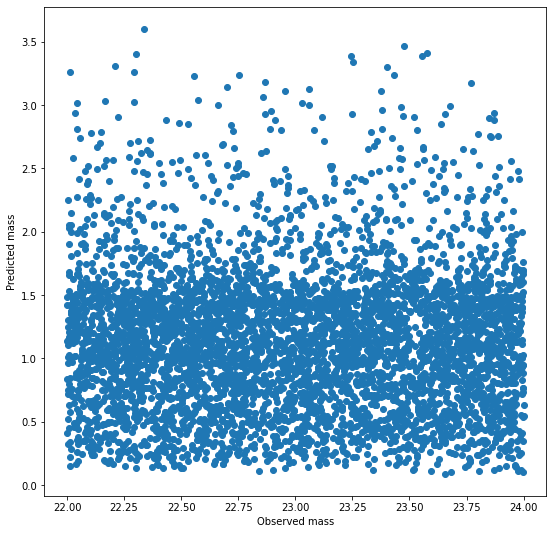

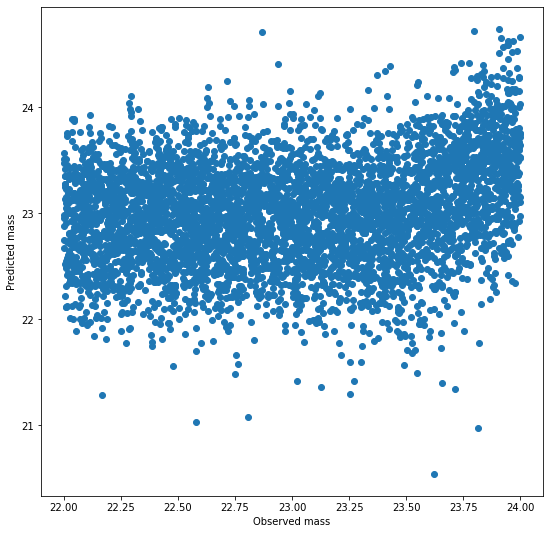

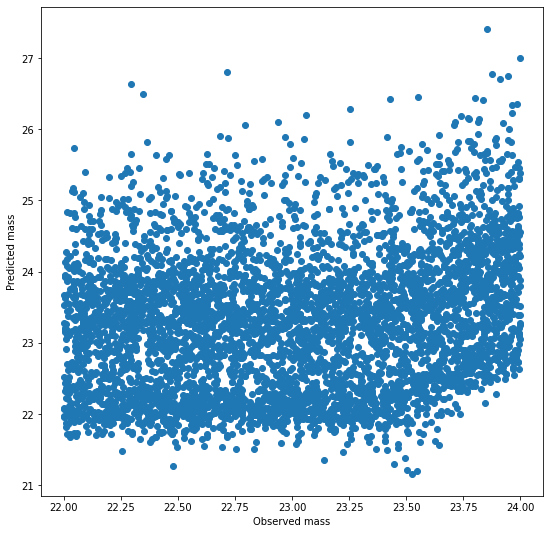

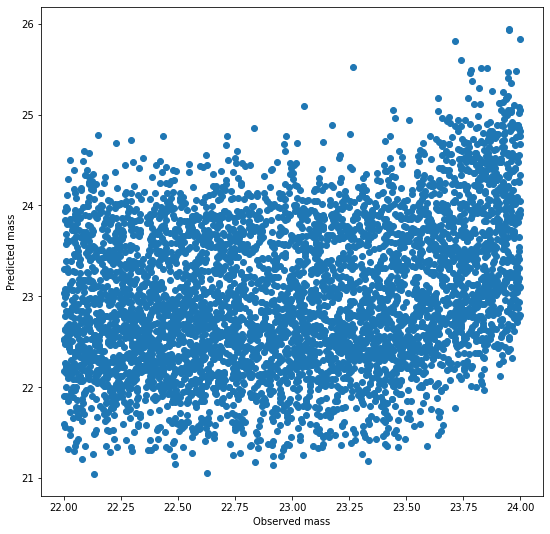

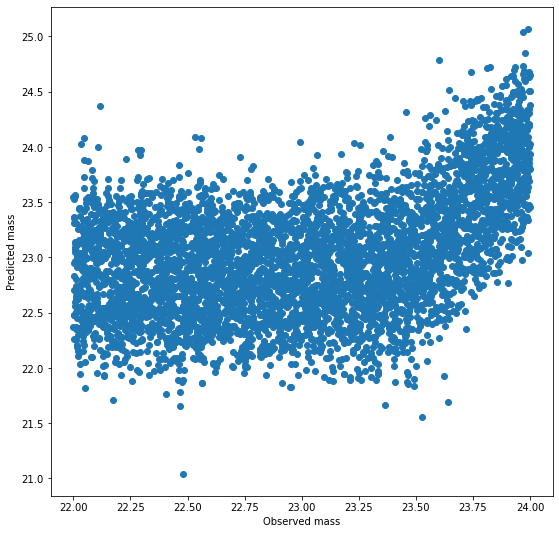

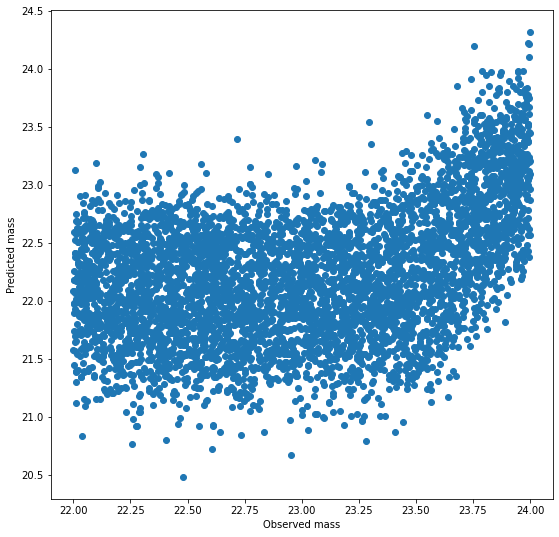

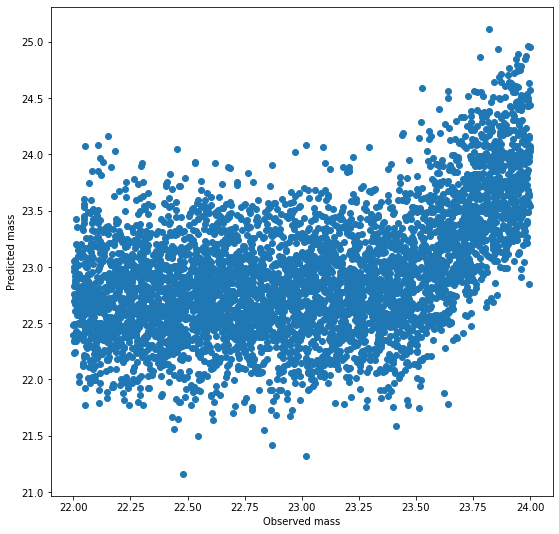

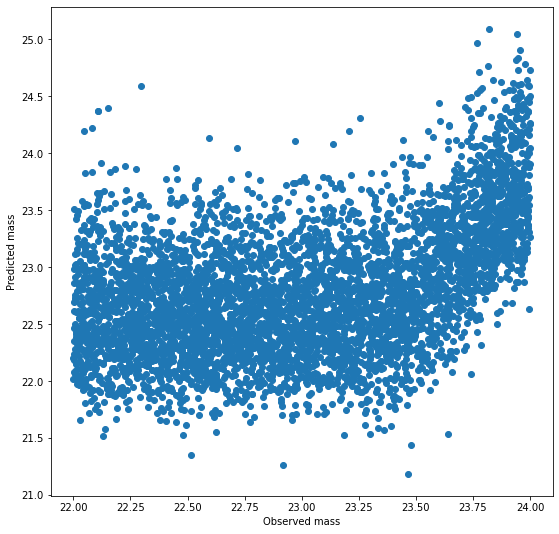

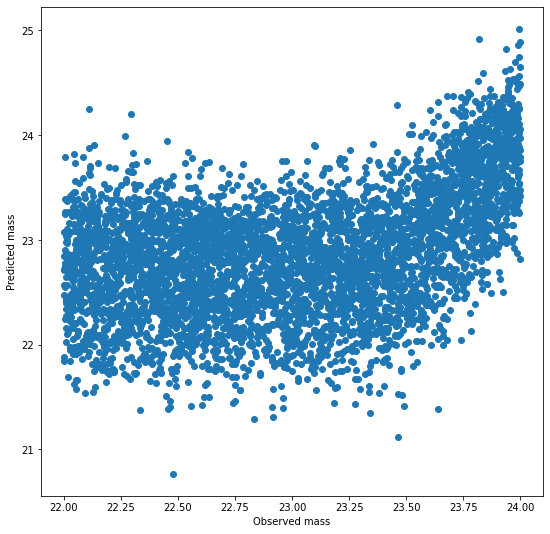

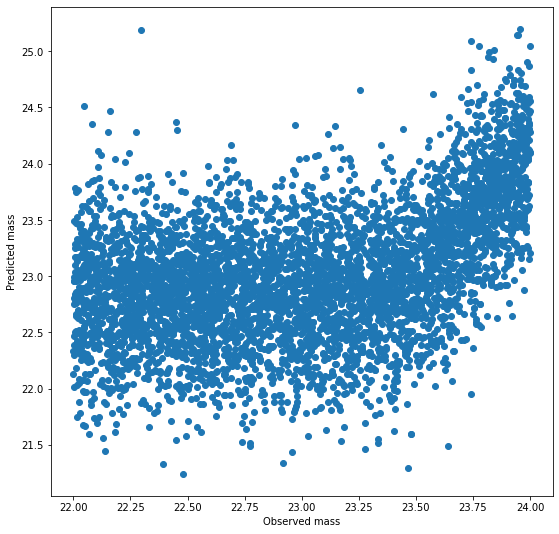

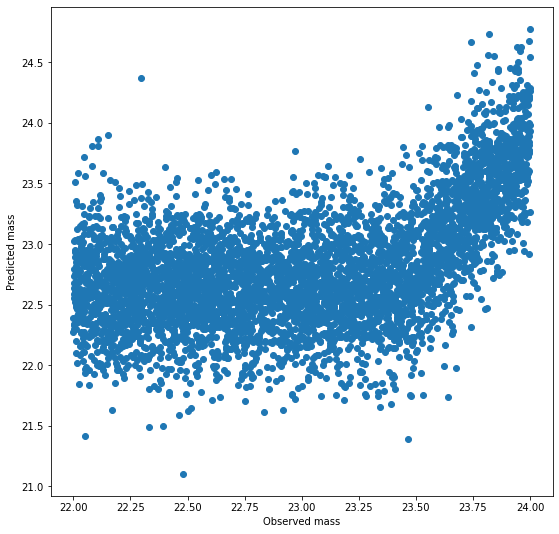

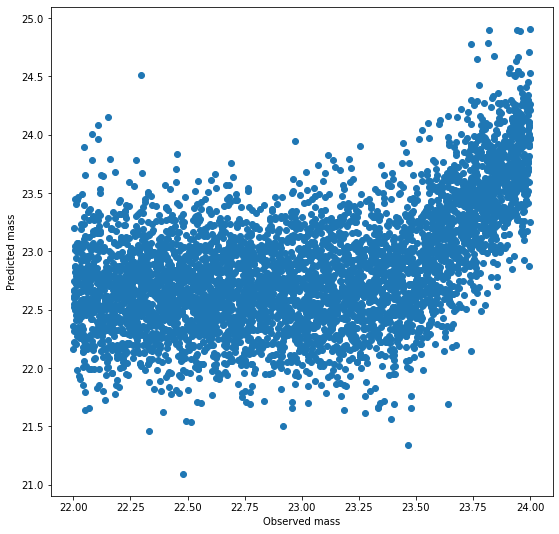

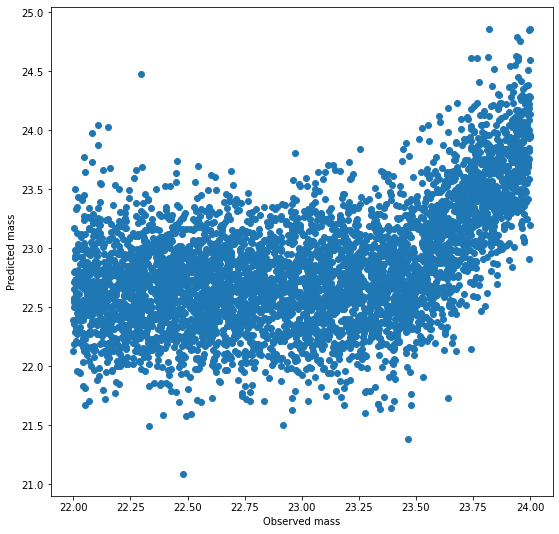

In [25]:
#training and tracking model
PATH = "basic_conv.pth"
model, loss_dict = fit_model(model, config, checkpoint_path = PATH)

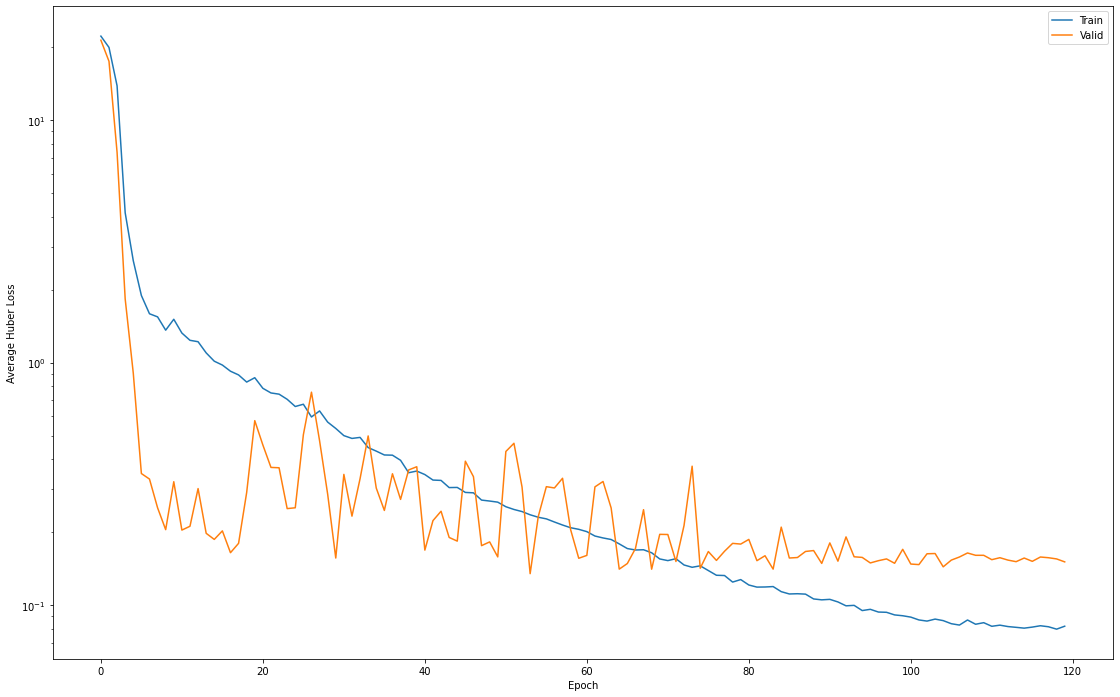

In [26]:
# Plot losses
plt.figure(figsize=(19,12))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Huber Loss')
#plt.grid()
plt.legend()
#plt.title('loss')


plot_name = "Loss_history"
plt.savefig(plot_name, format="png", dpi=80)  
pic = Image.open(plot_name)
wandb.log({plot_name: [wandb.Image(pic, caption = f"Train, Val Huber loss history")]})

plt.show()

In [27]:
del model
gc.collect()

model = Regressor().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
criterion = nn.HuberLoss()

_, _, train_mse = test_epoch(model, train_loader, criterion)
print("Train set Huber Loss:" + str(train_mse))

_, _, val_mse = test_epoch(model, val_loader, criterion)
print("Val set Huber Loss:" + str(val_mse))

_, _, test_mse = test_epoch(model, test_loader, criterion)
print("Test set Huber Loss:" + str(test_mse))

  0%|          | 0/407 [00:00<?, ?it/s]

Train set Huber Loss:0.07413617


  0%|          | 0/46 [00:00<?, ?it/s]

Val set Huber Loss:0.13495716


  0%|          | 0/79 [00:00<?, ?it/s]

Test set Huber Loss:0.14071372


In [29]:
scores = [[train_mse, val_mse, test_mse]]

wandb.log({"Huber_Loss_Scores": wandb.Table(data = scores, columns=["Train_loss", "Val_loss", "Test_loss"])})

  0%|          | 0/79 [00:00<?, ?it/s]

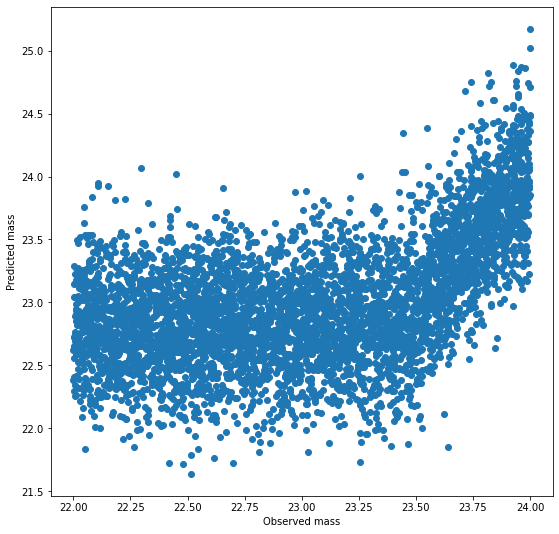

In [30]:
y_pred_list, y_truth_list, test_loss = test_epoch(model, test_loader, criterion)
    
def flatten_list(x):
    flattened_list = []
    for i in x:
        for j in i:
            flattened_list.append(j)

    return flattened_list

y_pred_list_flattened = flatten_list(y_pred_list)
y_truth_list_flattened = flatten_list(y_truth_list)

plt.figure(figsize=(9,9))
plt.scatter(y_truth_list_flattened, y_pred_list_flattened)
plt.xlabel('Observed mass')
plt.ylabel('Predicted mass')

plot_name = f"test_plot"
plt.savefig(plot_name, format="png", dpi=80)  
pic = Image.open(plot_name)

wandb.log({plot_name: [wandb.Image(pic, caption = f"Test Set predictions")]})
plt.show()

In [31]:
wandb.finish()